# Using Fourier Series epicycles to draw an arbitrary path

The Fourier Series has a wide variety of applications in physics phenomena, but it was developed by Fourier as a means to approximate an arbitrary signal into a bunch of sine waves of varying frequencies scaled by certain constants governing decay. This series can be further expanded using the representation of a sine/cosine wave as a sum of rotating vectors (epicycles) $e^{2\pi i t}$ and $e^{-2\pi i t}$, and gives us:

\begin{equation}
f(t) = \sum_{-n}^n c_{-n} e^{-n.2\pi.i.t } = \left( ... c_{-2} e^{-2.2\pi.i.t } + c_{-1} e^{-1.2\pi.i.t } + c_0 + c_1 e^{1.2\pi.i.t } + c_2 e^{2.2\pi.i.t } ... \right)
\end{equation}

where f(t) is the parametric representation of the path to be drawn in terms of t where $0 \leq t \leq 1$, represented as a complex number $z = x + iy$.

The Fourier Transform allows one to break down a signal consisting of multiple frequencies into it's component frequencies: unsmoothing a smoothie, if you will. Given the terms above, integrating the series over $t = [0,1]$ will allow us to calculate the constant $c_0$. Shifting the original signal f(t) by the rotating vector $e^{-n.2\pi.i.t }$ enables us to use the Fourier Transform and find the constant corresponding to the $n^{th}$ epicycle.

The general formula for each constant would be:

\begin{equation}
c_n = \int_{0}^1 f(t) e^{-n.2\pi.i.t } \, dt
\end{equation}

and then use these constants to initialize the epicycles at the right position in order to draw the path.

In [ ]:
import math, sys
import cmath as z

!{sys.executable} -m pip install numpy matplotlib svgpathtools

In [2]:
%matplotlib notebook
import numpy as np 
import matplotlib.animation as anim 
import matplotlib.pyplot as plt
from svgpathtools import svg2paths
from IPython.display import HTML

Adjust the number of vectors (N) used to approximate the path here:

In [3]:
# No. of vectors
N = 51

This notebook comes with a sample SVG file for demonstration purposes, but you should be able to draw the longest path from any SVG of your choice. Be sure to place the SVG in the working directory, and pass it to the ```svg2paths()``` method below.

Note: Only the longest path in the SVG will be drawn.

In [4]:
# Sample path from SVG
paths, attributes = svg2paths('note.svg')

# Fetch correct path from list
path = max(paths, key= lambda k:k.length(error=1e-5))
xlim1, xlim2, ylim1, ylim2 = path.bbox()  # Get SVG path bounding box dimensions
centre = (xlim1+xlim2)/2 + 1j*(ylim1+ylim2)/2  # Get centre of path to shift origin

PI = math.pi
# Time signal for parameterizing curve
t = np.arange(0,N/(N-1),1/(N-1))
dt = 1/(N-1)

In [5]:
# Vectors 
class epicycle:
    
    # Initialized via constants calculated from Fourier Transform
    def __init__(self, cn, n, t): 
        self.term = cn*z.exp(n*2*PI*1j*t)
        
    # Return vector coordinates
    def data(self):
        return self.term.real, -self.term.imag  # Mirror along x-axis for CCW representation


# Returns parametric coordinates of path as complex numbers
def f(t):
    return path.point(t)-centre   # Shift origin


The Discrete Fourier Transform is an approximation of the Fourier Transform integral mentioned above, and is as follows:
\begin{equation}
c_n = \sum_{t=0}^1 f(t) e^{-n.2\pi.i.t } \, \Delta t
\end{equation}

We use this to create a generator of constants for the Fourier Series.

In [6]:
# Discrete Fourier Transform
def dft(n,N):
    cn = 0
    t = 0
    while t <= 1:
        cn += f(t)*z.exp(-n*2*PI*1j*t)*(1/(N-1))
        t += 1/(N-1)
    
    return cn,n

# Generator of constants for epicycles
def constants(N):    
    for n in range(N):
        n -= N//2
        yield dft(n,N)

<IPython.core.display.Javascript object>


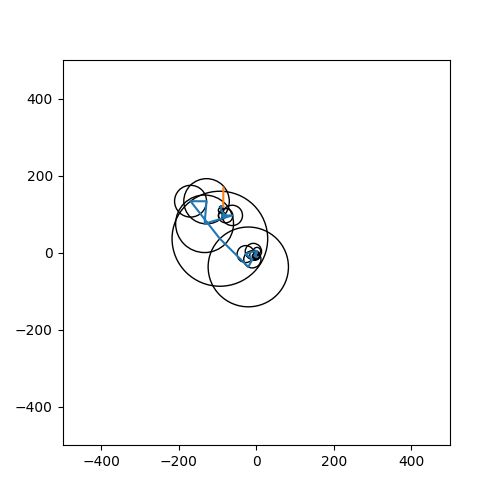

In [7]:
# Matplotlib
fig = plt.figure(figsize=(5,5))
plt.xlim(-500, 500)
plt.ylim(-500, 500)
epicycles, = plt.plot([],[])
_path, = plt.plot([],[])

def init():
    # Clear vector data before animation loop
    epicycles.set_data([],[])
    return epicycles,

def animate(t):    
    # Clear old circle artists
    for obj in plt.findobj(match=type(plt.Circle(1,1))):
        obj.remove()
                           
    # Update epicycle data and path drawn
    _x,_y = [],[]
    x, y = 0,0
    circles = []
    for cn, n in constants(N):
        _vector = epicycle(cn,n,t)
        r,i = _vector.data()
        radius = math.sqrt(r**2 + i**2)
        _circle = plt.Circle((x,y),radius,fill=False)
        fig.gca().add_artist(_circle)
        circles.append(_circle)
        x += r
        y += i
        _x.append(x)
        _y.append(y)

    if t == 0:
        fx, fy = [],[]
    else:
        fx = _path.get_xdata()
        fy = _path.get_ydata()

    fx = np.append(fx,x)
    fy = np.append(fy,y)

    epicycles.set_data(_x, _y)
    _path.set_data(fx, fy)
    return epicycles, _path, circles

# Animate path drawing
final = anim.FuncAnimation(fig,animate,t,interval=dt*3000,blit=True,repeat_delay=200,init_func=init)
#HTML(final.to_jshtml()) ## In case the above doesn't work